# Models for deep research of ECG

CardIO framework provides a flexible environment for experiments with deep neural network models and models of other kind. In this tutorial we will start with examples how to use models built-in in CardIO. We will train them to make a segmentation of ECGs and detect heart diseases. Then we will elaborate a custom model using standard blocks and layers provided with CardIO. Thanks to them the process of configuring even a deep neural network is as simple as building a castle from LEGO blocks.
![](http://c.shld.net/rpx/i/s/i/spin/10000351/prod_1876279212?hei=245&wid=245&op_sharpen=1&qlt=85)
Any other models related or not related to neural networks are also welcome using CardIO API for general models, which we consider in the last part of this tutorial. 

## Table of contents
* [CardIO segmentation models](#CardIO-segmentation-models)
    * [Train segmentation model](#Train-segmentation-model)
    * [ECG segmentation](#ECG-segmentation)
* [CardIO classification models](#CardIO-classification-models)
    * [Train classification model](#Train-classification-model)
    * [Predict atrial fibrillation](#Predict-atrial-fibrillation)
* [Common neural network architectures](#Common-neural-network-architectures)
* [Custom neural network models](#Custom-neural-network-models)
    * [Layers and blocks from Batchflow models](#Layers-and-blocks-from-Batchflow-models)
    * [Neural network with Tensorflow](#Neural-network-with-Tensorflow)
    * [Neural network with Keras](#Neural-network-with-Keras)
* [General models](#General-models)
* [Summary](#Summary)

# CardIO segmentation models

Analysis of ECG typically starts with isolation of fiducial points within an ECG signal. The figure below (taken from internet) shows various types of that points.

![](https://archive.cnx.org/resources/c36f8642adfe54b796f9a94593f1be08e6fee4c9/Picture%201.jpg)

CardIO contains a model designed to automatically isolate QRS intervals, P-waves and T-waves. The model is based on Hidden Markov Model approach (read the [article](https://medium.com/data-analysis-center/annotating-ecg-signals-with-hidden-markov-model-56f8b9abd83a) to see how it works). We consider the model as a "black box" without looking under the hood (however, you can always find its description in source [code](https://github.com/analysiscenter/cardio/blob/master/cardio/models/hmm/hmm.py)). First, we will train the model using provided pipeline. Then we will apply the pipeline for segmentation.

## Train segmentation model

To start training we need a database with isolated fiducial points. We suggest to use PhysioNet QT [Database](https://www.physionet.org/physiobank/database/qtdb/), which consists of 105 annotated 15-minute excerpts of two channel ECG. So, download the database to follow the tutorial.

After downloading the database we make a training dataset as follows:

In [1]:
import sys, os
sys.path.append('..')

from cardio import EcgDataset

SIGNALS_PATH = "/notebooks/data/ECG/QT/" #set path to the QT database
SIGNALS_MASK = os.path.join(SIGNALS_PATH, "*.hea")

dtst = EcgDataset(path=SIGNALS_MASK, no_ext=True, sort=True)

There are two steps in model training. The first one is signal preprocessing described in ```hmm_preprocessing_pipeline``` (see previous [Notebook 2](https://github.com/analysiscenter/cardio/blob/master/tutorials/II.Pipelines.ipynb) for pipelines). Then we apply  ```hmm_train_pipeline```. 

We import both pipelines from ```cardio.pipelines``` and organize the process as shown below. Note that pipelines' runtime may take up to several hours. You can reduce the training dataset to speed up the process.

In [2]:
from cardio.pipelines import hmm_preprocessing_pipeline, hmm_train_pipeline
import warnings
warnings.filterwarnings('ignore')

pipeline = hmm_preprocessing_pipeline()
ppl_inits = (dtst >> pipeline).run()

pipeline = hmm_train_pipeline(ppl_inits)
ppl_train = (dtst >> pipeline).run()

After both pipelines are completed, don't forget to save the trained model for later use:

In [3]:
ppl_train.save_model("HMM", path="model_dump.dll")

## ECG segmentation

For segmentation we use ```hmm_predict_pipeline``` defined in ```cardio.pipelines```. Below we create a dataset for segmentation, import ```hmm_predict_pipeline``` and run it:

In [4]:
from cardio import EcgDataset
from cardio.pipelines import hmm_predict_pipeline
import warnings
warnings.filterwarnings('ignore')

eds = EcgDataset(path="../cardio/tests/data/A*.hea", no_ext=True, sort=True)
batch = (eds >> hmm_predict_pipeline("model_dump.dll", annot="hmm_annotation")).next_batch()

Using TensorFlow backend.


Now ```res``` contains batch with annotated intervals. Let's visualize e.g. ECG with index 'A00001'. Red color in the figure represents QRS-intervals, green is for P-waves, blue is for T-waves.

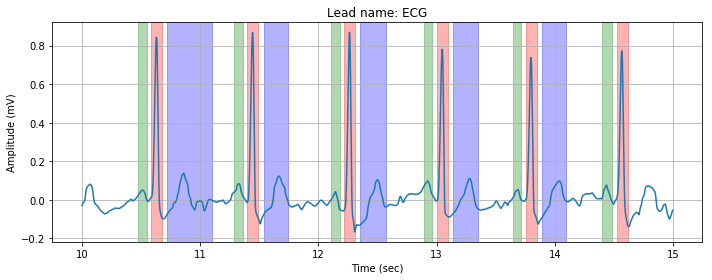

In [5]:
batch.show_ecg("A00001", start=10, end=15, annot="hmm_annotation")

ECG signal with isolated QRS intervals allows to calculate heart rate parameter. In fact, it has been already done in ```hmm_predict_pipeline``` and we can find heart rate in ```meta``` component. For instance, let's check heart rate's value for the same signal 'A00001':

In [6]:
print("Heart rate: {0} bpm".format(int(.5 + batch["A00001"].meta["hr"])))

Heart rate: 79 bpm


Note that in meta there are also available computed median lengths of the PQ interval (key ```"pq"```), the QT interval (```"qt"```) and the QRS interval (```"qrs"```).

# CardIO classification models

CardIO can predict heart diseases using ECG signals. In the tutorial we will show how to train a model to predict atrial fibrillation. The figure below (taken from internet) schematically shows what differs normal rhythm from atrial fibrillation.

![](https://i.pinimg.com/564x/00/2b/88/002b88cebc5eda5e80a3046a136fd7a1--atrial-fibrillation-ecg.jpg)

To train a model we will use the PhysioNet's short single lead ECG recording [database](https://physionet.org/challenge/2017/). To continue with the tutorial download the PhysioNet's database.

Read the [article](https://medium.com/data-analysis-center/atrial-fibrillation-detection-with-a-deep-probabilistic-model-1239f69eff6c) for description of the model or find its source code in the [repository](https://github.com/analysiscenter/cardio/blob/master/cardio/models/dirichlet_model/dirichlet_model.py). We only note that it's a deep neural network of ResNet-like architecture.


## Train classification model

First we construct a dataset from the PhysioNet database:

In [7]:
import sys, os
sys.path.append("..")
from cardio import EcgDataset

AF_SIGNALS_PATH = "/notebooks/data/ECG//training2017" #set path to the PhysioNet database
AF_SIGNALS_MASK = os.path.join(AF_SIGNALS_PATH, "*.hea")
AF_SIGNALS_REF = os.path.join(AF_SIGNALS_PATH, "REFERENCE.csv")

afds = EcgDataset(path=AF_SIGNALS_MASK, no_ext=True, sort=True)

afds.split(0.8)

Then we import  ```dirichlet_train_pipeline``` and run it. The process may take a while, we recommend to ensure that GPU is enabled. You can also set ```n_epochs``` parameter of the pipeline to lower value (default is ```n_epochs```=1000).

In [8]:
from cardio.pipelines import dirichlet_train_pipeline

pipeline = dirichlet_train_pipeline(AF_SIGNALS_REF)
train_ppl = (afds.train >> pipeline).run()

Using TensorFlow backend.


Check how loss decreases with epochs increasing. We access ```loss_history``` through ```get_variable()``` method:

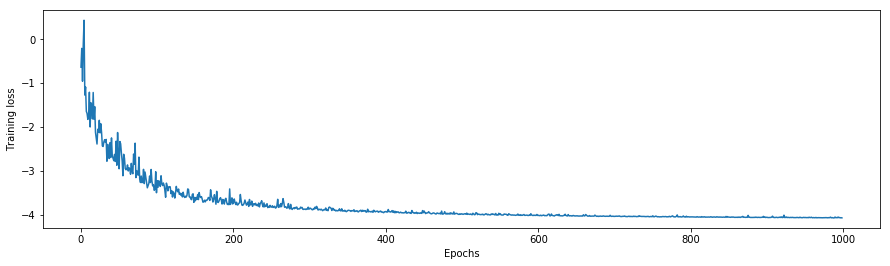

In [9]:
import matplotlib.pyplot as plt
import numpy as np

train_loss = train_ppl.get_variable("loss_history")

fig = plt.figure(figsize=(15, 4))
plt.plot(train_loss)
plt.xlabel("Epochs")
plt.ylabel("Training loss")
plt.show()

Save model for later use:

In [10]:
train_ppl.save_model("dirichlet", path="af_model_dump")

## Predict atrial fibrillation

We predict atrial fibrillation through ```dirichlet_predict_pipeline```. Below we initialize the pipeline and run it on the test part of the dataset:

In [11]:
from cardio.pipelines import dirichlet_predict_pipeline

pipeline = dirichlet_predict_pipeline(model_path="af_model_dump")
res = (afds.test >> pipeline).run()

INFO:tensorflow:Restoring parameters from af_model_dump/model-13000


Now ```res``` contains ```predictions_list```, which we access through ```get_variable()``` method: 

In [12]:
pred = res.get_variable("predictions_list")

Output predicted probabilities:

In [13]:
import pandas as pd
pd.options.display.float_format = '{:.2f}'.format

pred_proba = pd.DataFrame([x["target_pred"]["A"] for x in pred], 
                    index=afds.test.indices, columns=['AF prob'])

true_labels = (pd.read_csv(AF_SIGNALS_REF, index_col=0, names=['True label'])
               .replace(['N', 'O', '~'], 'NO'))

df = pd.merge(pred_proba, true_labels, how='left', left_index=True, right_index=True)
df.head(10)

,AF prob,True label
A00001,0.04,NO
A00002,0.03,NO
A00003,0.03,NO
A00004,0.82,A
A00005,0.69,A
A00006,0.13,NO
A00007,0.03,NO
A00008,0.03,NO
A00009,0.95,A
A00010,0.03,NO


Print some classification metrics to quantify the quality of predictions:

In [14]:
from sklearn.metrics import classification_report

print(classification_report((df['True label'] == 'A').astype(int),
                            (df['AF prob'].astype(float) >= 0.5).astype(int)))

             precision    recall  f1-score   support

          0       1.00      0.97      0.99      1533
          1       0.81      0.98      0.89       173

avg / total       0.98      0.98      0.98      1706



We observe that the model is able to detect atrial fibrillarion reasonably well. Note that ```predictions_list``` contains not only predictions, but also confidence in that predictions. Read the [article](https://medium.com/data-analysis-center/atrial-fibrillation-detection-with-a-deep-probabilistic-model-1239f69eff6c) for more details.

# Common neural network architectures

![](http://joelouismarino.github.io/images/blog_images/blog_googlenet_keras/googlenet_components.png)

Apart from exploiting the ECG-specific models implemented in CardIO, you can also experiment with benchmark models for common segmentation and classification tasks. These are e.g. VGG, ResNet, UNet, DenseNet and several other models. They were carefully implemented in Batchflow submodule which is a part of CardIO module. It means that you can import desired architecture, e.g. Inception-v1 which is schematically shown in the figure above, with a single line of code:
```python
from cardio.batchflow.models.tf import Inception_v1
```
and immediately start using it. Below we demonstrate how it works. The full list of ready-to-use architectures is given in [documentation](https://analysiscenter.github.io/batchflow/intro/tf_models.html#ready-to-use-models).

### Import data and model

First we construct a dataset from the PhysioNet database:

In [15]:
import sys, os
sys.path.append("..")
from cardio import EcgDataset

AF_SIGNALS_PATH = "/notebooks/data/ECG/training2017" #set path to PhysioNet database
AF_SIGNALS_MASK = os.path.join(AF_SIGNALS_PATH, "*.hea")
AF_SIGNALS_REF = os.path.join(AF_SIGNALS_PATH, "REFERENCE.csv")

afds = EcgDataset(path=AF_SIGNALS_MASK, no_ext=True, sort=True)

afds.split(0.8)

Let's import ```Inception_v1``` model:

In [16]:
from cardio.batchflow.models.tf import Inception_v1

### Configure model

In the next step we configure the model. Let's see into ```model_config```. It states that:
* inputs for the model are signals and labels
* shape of signals will be computed directly from batch
* labels will be transformed from original classes 'A' and 'NO' using one-hot-encoding ('ohe')
* ```signals``` will be considered as feature vector
* we have total 2 classes
* loss is crossentropy
* we use Adam optimizer
* output will be transformed to probabilities (default are logits).

Note how we set ```shape``` parameter. Since batches will appear only when pipeline will be run, a specific substitution rule is required to obtain batch shape. This rule is given by named expression ```F```, which accepts ```batch``` and returns shape of batch items. Read more about named expressions in [documentation](https://analysiscenter.github.io/batchflow/intro/named_expr.html).

In [17]:
from cardio.batchflow import F

model_config = {
    'inputs': dict(signals={'shape': F(lambda batch: batch.signal[0].shape[1:]), 'data_format': 'channels_first' },
                   labels={'classes': ['A', 'NO'], 'transform': 'ohe', 'name': 'targets'}),
    'initial_block/inputs': 'signals',
    'body/n_classes': 2,
    "loss": "crossentropy",
    "optimizer": "Adam",
    'output': 'proba'
}

Now we define how to extract signals and labels from batch. We say that ```signals``` is batch component ```signal``` and ```labels``` is batch component ```targets```. For prediction we do not have labels and ```feed_dict``` contains only ```signals```.

In [18]:
def make_signals(batch):
    return np.array([segment for signal in batch.signal for segment in signal])

def make_targets(batch):
    n_reps = [signal.shape[0] for signal in batch.signal]
    return np.repeat(batch.target, n_reps, axis=0)

def make_data(batch, **kwagrs):
    if any(elem is None for elem in batch.target):
        return {"feed_dict": {'signals': make_signals(batch)}}
    else:
        return {"feed_dict": {'signals': make_signals(batch), 'labels': make_targets(batch)}}

### Train model

To train the model we construct a ```train_pipeline```. Within the pipeline we initialize the ```Inception_v1``` model with given model_config, initialize variable to store loss, load and preprocess signals, convert signal to spectrogram and train the model.

In [19]:
import numpy as np
import cardio.batchflow as bf
from cardio.batchflow import V
import tensorflow as tf

train_pipeline = (bf.Pipeline()
                  .init_model("dynamic", Inception_v1, name="inception_model", config=model_config)
                  .init_variable("loss_history", init_on_each_run=list)
                  .load(fmt="wfdb", components=["signal", "meta"])
                  .load(src=AF_SIGNALS_REF, fmt="csv", components="target")
                  .drop_labels(["~"])
                  .rename_labels({"N": "NO", "O": "NO"})
                  .drop_short_signals(4000)
                  .random_split_signals(3000, 3)
                  .spectrogram(nperseg=100, noverlap=50)
                  .train_model("inception_model", make_data=make_data, fetches="loss",
                               save_to=V("loss_history"), mode="a"))

Run ```train_pipeline```:

In [20]:
model_trained = (afds.train >> train_pipeline).run(batch_size=50, n_epochs=100, shuffle=True, drop_last=True)

Now ```model_trained``` contains trained model and loss history. Method ```get_variable``` allows to get ```loss_history``` and we can plot it:

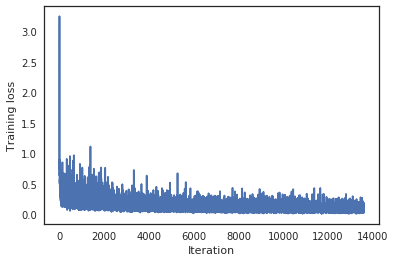

In [21]:
import matplotlib.pyplot as plt

plt.plot(model_trained.get_variable("loss_history"))
plt.xlabel("Iteration")
plt.ylabel("Training loss")
plt.show()

### Make predictions

For predictions we create ```predict_pipeline```. It differs from ```train_pipeline``` in several things. First, we import trained model instead of initializing a new one. Then we do not process signal labels and apply ```predict_model``` instead of ```train_model``` action.

In [22]:
predict_pipeline = (bf.Pipeline()
                    .import_model("inception_model", model_trained)
                    .init_variable("predictions_list", init_on_each_run=list)
                    .load(fmt="wfdb", components=["signal", "meta"])
                    .random_split_signals(3000, 1)
                    .spectrogram(nperseg=100, noverlap=50)
                    .predict_model('inception_model', make_data=make_data,
                                   fetches='proba', save_to=V("predictions_list"), mode="e"))

Run ```predict_pipeline``` on the test part of the dataset:

In [23]:
res = (afds.test >> predict_pipeline).run(batch_size=len(afds.test), n_epochs=1, shuffle=False, drop_last=False)

Consider predicted values and true labels. Predictions are stored in ```predictions_list``` and we get them through ```get_variable``` method:

In [24]:
import pandas as pd
pd.options.display.float_format = '{:.2f}'.format

pred_proba = pd.DataFrame([x[0] for x in res.get_variable("predictions_list")], 
                    index=afds.test.indices, columns=['AF prob'])

true_labels = (pd.read_csv(AF_SIGNALS_REF, index_col=0, names=['True label'])
               .replace(['N', 'O', '~'], 'NO'))

df = pd.merge(pred_proba, true_labels, how='left', left_index=True, right_index=True)
df.head(10)

,AF prob,True label
A00001,0.00,NO
A00002,0.01,NO
A00003,0.00,NO
A00004,0.90,A
A00005,0.59,A
A00006,0.00,NO
A00007,0.00,NO
A00008,0.00,NO
A00009,0.88,A
A00010,0.00,NO


In [25]:
from sklearn.metrics import classification_report

print(classification_report((df['True label'] == 'A').astype(int),
                            (df['AF prob'].astype(float) >= 0.5).astype(int),
                            target_names = ['NO', 'A']))

             precision    recall  f1-score   support

         NO       0.96      0.99      0.98      1533
          A       0.87      0.68      0.76       173

avg / total       0.96      0.96      0.95      1706



We observe that this classification model is not as well as ECG-specific model. However, it is interesting to experiment with other standard architectures and check their ability to predict atrial fibrillation.

# Custom neural network models

![](http://www.opennn.net/images/deep_neural_network.png)

There are two types of models that one can build with CardIO: *static* and *dynamic*. *Static* means that all model hyperparameters (input shape, loss function, optimizer etc) are hardcoded once and remain unchanged. However, it would be more convenient if input shape would be automatically computed from batch shape or we could control and vary hyperparameters in pipeline. This means we need a *dynamic* model. Dynamic model receives configuration parameters from pipeline and compiles model according to that parameters. 

In the next section we will build the same neural network model with different frameworks: 
* using custom layers and blocks from Batchflow.models
* TensorFlow
* Keras

The model architecture will be as simple as several convolutional blocks. Each convolutional block consists of 4x1 convolutional layer, batch normalization, relu activation and 2x1 max-pooling with stride 2. Number of filters will increase as 8, 16, 32, 64 for successive blocks. In the end of the network we apply global max pooling and dense layer with 2 outputs. Below is the diagram with model architecture:  

![](conv_block.PNG)

This model can be used e.g. for detection of atrial fibrillation. We will run model on PhysioNet's short single lead ECG recording database which we already used in this tutorial. You can recreate it now if neccessary.

In [26]:
import sys, os
sys.path.append("..")
from cardio import EcgDataset

AF_SIGNALS_PATH = "/notebooks/data/ECG/training2017" #set path to PhysioNet database
AF_SIGNALS_MASK = os.path.join(AF_SIGNALS_PATH, "*.hea")
AF_SIGNALS_REF = os.path.join(AF_SIGNALS_PATH, "REFERENCE.csv")

afds = EcgDataset(path=AF_SIGNALS_MASK, no_ext=True, sort=True)

afds.split(0.8)

Moreover, we will use one pipeline for signal preprocess. It looks as follows:

In [27]:
import numpy as np
import cardio.batchflow as bf

preprocess_pipeline = (bf.Pipeline()
                       .load(fmt="wfdb", components=["signal", "meta"])
                       .load(src=AF_SIGNALS_REF, fmt="csv", components="target")
                       .drop_labels(["~"])
                       .rename_labels({"N": "NO", "O": "NO"})
                       .drop_short_signals(4000)
                       .random_split_signals(3000, 3)
                       .apply_transform(func=np.transpose, src='signal', dst='signal', axes=[0, 2, 1]))

This pipeline loads signal and targets, drops noise signals, replaces all non-arrhythmia labels with "NO" labels, randomly splits signal to 3 segmets of length 3000 and unstack batch.

## Layers and blocks from Batchflow models

CardIO includes various standard layers and blocks in its Batchflow submodule. You can easily construct a very deep neural network concatenating simple elements. 

### Define model architecture

We are going to build a simple model that consists of convolution blocks, pooling and dense layers. There is no need to define convolution block, instead we import it from standard ```cardio.batchflow.models.tf.layers``` and configure it. Let's consider how to configure convolution block.

```python
from cardio.batchflow.models.tf.layers import conv_block

outputs = conv_block(inputs, layout='cnap', filters=16, kernel_size=4)
```

Layout 'cnap' means that convolution block consists of convolution layer ('c'), batch normalization ('n'), activation ('a') and max pooling ('p'). Alternatively, one could set 'ccnap' to double convolutions, or set 'cap' to exclude batch normalization. Parameter ```filters``` sets number of filters for each 'c'. If you have several 'c' letters in layout, then ```filters``` can be a single value or array of the same length as number of 'c' letters in layout.

Using ```conv_block``` we easily build our simple model. Note that ```ConvModel``` is a _dynamic_ model and will receive several hyperparameters from pipeline. For instance, it will receive number of filters for each convolution block.

In [28]:
from cardio.batchflow.models.tf import TFModel
from cardio.batchflow.models.tf.layers import conv_block, global_max_pooling

class ConvModel(TFModel):
    def body(self, inputs, **kwargs):
        conv = inputs
        conv = conv_block(conv, 'cnap' * len(kwargs['filters']), kwargs['filters'], kernel_size=4)
        flat = global_max_pooling(conv)
        logits = tf.layers.dense(flat, self.num_classes('targets'))
        return logits

### Configure model

In the next step we configure the model. Let's see into ```model_config```. It states that:
* inputs for the model are signals and labels
* shape of signals will be computed directly from batch
* labels will be transformed from original classes 'A' and 'NO' using one-hot-encoding ('ohe')
* ```signals``` will be considered as feature vector
* we have total 2 classes
* loss is crossentropy
* we use Adam optimizer
* number of filters for convolutions is [8, 16, 32, 64]
* output will be transformed to probabilities (default are logits)

Note how we set ```shape``` parameter. Since batches will appear only when pipeline will be run, a specific substitution rule is required to obtain batch shape. This rule is given by named expression ```F```, which accepts ```batch``` and returns shape of batch items. Read more about named expressions in [documentation](https://analysiscenter.github.io/batchflow/intro/named_expr.html).

In [29]:
from cardio.batchflow import F

model_config = {
    'inputs': dict(signals={'shape': F(lambda batch: batch.signal[0].shape[1:])},
                   labels={'classes': ['A', 'NO'], 'transform': 'ohe', 'name': 'targets'}),
    'initial_block/inputs': 'signals',
    'body/n_classes': 2,
    "loss": "crossentropy",
    "optimizer": "Adam",
    'body/filters': [4, 4, 8, 8, 16, 16, 32, 32],
    'output': 'proba'
}

Now we define how to extract signals and labels from batch. We say that ```signals``` is batch component ```signal``` and ```labels``` is batch component ```targets```. For prediction we do not have labels and ```feed_dict``` contains only ```signals```.

In [30]:
def make_signals(batch):
    return np.array([segment for signal in batch.signal for segment in signal])

def make_targets(batch):
    n_reps = [signal.shape[0] for signal in batch.signal]
    return np.repeat(batch.target, n_reps, axis=0)

def make_data(batch, **kwagrs):
    if any(elem is None for elem in batch.target):
        return {"feed_dict": {'signals': make_signals(batch)}}
    else:
        return {"feed_dict": {'signals': make_signals(batch), 'labels': make_targets(batch)}}

### Train model

To train a model we construct ```train_pipeline```. It initializes ```ConvModel``` with given ```model_config```, initializes variable to store loss, preprocesses signals and trains model:

In [31]:
from cardio.batchflow import Pipeline, V
import tensorflow as tf

with Pipeline() as p:
    train_pipeline = (p.init_model("dynamic", ConvModel, name="conv_model", config=model_config)
                      +
                      p.init_variable("loss_history", init_on_each_run=list)
                      +
                      preprocess_pipeline
                      +
                      p.train_model('conv_model', make_data=make_data, fetches="loss",
                                    save_to=V("loss_history"), mode="a"))

Run ```train_pipeline```:

In [32]:
model_trained = (afds.train >> train_pipeline).run(batch_size=256, n_epochs=100, shuffle=True, drop_last=True)

Now ```model_trained``` contains trained model and loss history. Method ```get_variable``` allows to get ```loss_history``` and we can plot it:

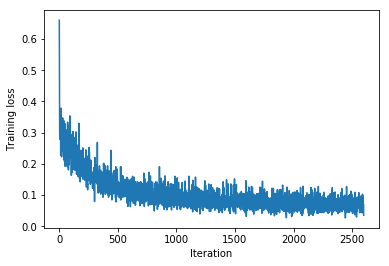

In [33]:
import matplotlib.pyplot as plt

plt.plot(model_trained.get_variable("loss_history"))
plt.xlabel("Iteration")
plt.ylabel("Training loss")
plt.show()

### Make predictions

For predictions we create ```predict_pipeline```. It differs from ```train_pipeline``` in several things. First, we import trained model instead of initializing a new one. Then we do not process signal labels and apply ```predict_model``` instead of ```train_model``` action.

In [34]:
predict_pipeline = (bf.Pipeline()
                    .import_model("conv_model", model_trained)
                    .init_variable("predictions_list", init_on_each_run=list)
                    .load(fmt="wfdb", components=["signal", "meta"])
                    .random_split_signals(3000, 1)
                    .apply_transform(func=np.transpose, src='signal', dst='signal', axes=[0, 2, 1])
                    .predict_model('conv_model', make_data=make_data,
                                   fetches='proba', save_to=V("predictions_list"), mode="e"))

Run ```predict_pipeline``` on the test part of the dataset:

In [35]:
res = (afds.test >> predict_pipeline).run(batch_size=len(afds.test), n_epochs=1, shuffle=False, drop_last=False)

Consider predicted values and true labels. Predictions are stored in ```predictions_list``` and we get them through ```get_variable``` method:

In [36]:
import pandas as pd
pd.options.display.float_format = '{:.2f}'.format

pred_proba = pd.DataFrame([x[0] for x in res.get_variable("predictions_list")], 
                    index=afds.test.indices, columns=['AF prob'])

true_labels = (pd.read_csv(AF_SIGNALS_REF, index_col=0, names=['True label'])
               .replace(['N', 'O', '~'], 'NO'))

df = pd.merge(pred_proba, true_labels, how='left', left_index=True, right_index=True)
df.head(10)

,AF prob,True label
A00001,0.00,NO
A00002,0.00,NO
A00003,0.00,NO
A00004,1.00,A
A00005,0.08,A
A00006,0.00,NO
A00007,0.00,NO
A00008,0.00,NO
A00009,0.93,A
A00010,0.00,NO


Print some classification metrics to quantify the quality of predictions:

In [37]:
from sklearn.metrics import classification_report

print(classification_report((df['True label'] == 'A').astype(int),
                            (df['AF prob'].astype(float) >= 0.5).astype(int),
                            target_names = ['NO', 'A']))

             precision    recall  f1-score   support

         NO       0.96      0.99      0.97      1533
          A       0.84      0.66      0.74       173

avg / total       0.95      0.95      0.95      1706



We observe that our simple ```ConvModel``` is too simple to detect atrial fibrillation reasonably well. Try to increase model depth and number of filters and see how it improves the classification.

## Neural network with Tensorflow

![](https://www.embedded-vision.com/sites/default/files/news/TensorFlowLogo.png?1495115697)

Let's write convolution block with TensorFlow. It may look as follows:

In [38]:
import tensorflow as tf

def tf_conv_block(input_layer, nb_filters, is_training):
        conv = tf.layers.conv1d(input_layer, nb_filters, 4)
        bnorm = tf.layers.batch_normalization(conv, training=is_training, momentum=0.9)
        relu = tf.nn.relu(bnorm)
        maxp = tf.layers.max_pooling1d(relu, 2, 2)
        return maxp

### Define model

In general, model is a complex object that includes model architecture, train/predict methods and some others features. However, if you are within TensorFlow, most of features are implemented in class [```TFModel```](https://analysiscenter.github.io/batchflow/intro/tf_models.html#configurationl) from ```batchflow.models.tf```. So, to build a custom model we define a class ```TFConvModel``` that extends ```TFModel``` and specify model architecture within ```_build``` method. Note that we do not hardcode input/output shapes and sequence of filter sizes, instead we will obtain these parameters from pipeline.

In [39]:
import sys, os
sys.path.append(os.path.join(".."))
import cardio.batchflow as bf

from cardio.batchflow.models.tf import TFModel

class TFConvModel(TFModel):
    def _build(self, config=None):
        with self.graph.as_default():
            x = tf.placeholder("float", (None,) + self.config['input_shape'])
            self.store_to_attr("x", x)
            y = tf.placeholder("float", (None, self.config['n_classes']))
            self.store_to_attr("y", y)
            conv = x
            for nb_filters in self.config['filters']:
                conv = tf_conv_block(conv, nb_filters, self.is_training)
            flat = tf.reduce_max(conv, axis=1)
            logits = tf.layers.dense(flat, self.config['n_classes'])
            output = tf.nn.softmax(logits)
            self.store_to_attr("output", output)
            if self.config['loss'] == 'binary_crossentropy':
                loss = tf.losses.softmax_cross_entropy(onehot_labels=y, logits=logits)
            else:
                raise KeyError('loss {0} is not implemented'.format(self.config['loss']))

### Configure model

```TFConvModel``` is a dynamic model and will receive configuration parameters from pipeline. We collect required configuration parameters in dict with name ```model_config``` that will be passed to pipeline. Note how we set ```input_shape```. Since batches will appear only when pipeline will be run, a specific substitution rule is required to obtain batch shape. This rule is given by named expression ```F```, which accepts ```batch``` and returns shape of batch items. Read more about named expressions in [documentation](https://analysiscenter.github.io/batchflow/intro/named_expr.html).

In [40]:
from cardio.batchflow import F

tf_model_config = {
    "input_shape": F(lambda batch: batch.signal[0].shape[1:]),
    "n_classes": 2,
    "loss": 'binary_crossentropy',
    "optimizer": "Adam",
    'filters': [4, 4, 8, 8, 16, 16, 32, 32]
}

Next step is function ```make_data```. This function defines what is `x` (features) and what is `y` (targets) for our model. We declare that batch component ```signal``` is `x`, while batch component ```target``` is `y`.

In [41]:
def make_signals(batch):
    return np.array([segment for signal in batch.signal for segment in signal])

def make_targets(batch):
    n_reps = [signal.shape[0] for signal in batch.signal]
    return np.repeat(batch.target, n_reps, axis=0)

def tf_make_data(batch, **kwagrs):
    if any(elem is None for elem in batch.target):
        return {"feed_dict": {'x': make_signals(batch)}}
    else:
        return {"feed_dict": {'x': make_signals(batch), 'y': make_targets(batch)}}

### Train pipeline

Let's combine all together in a single pipeline. In the beginning we initialize model ```TFConvModel``` and indicate configuration parameters. Then we add preprocess pipeline. In the end we add action ```train_model``` and indicate ```make_data``` functions. Output of ```train_model``` (loss on each batch) will be saved to pipeline variable ```loss_history```: 

In [42]:
from cardio.batchflow import Pipeline, V

with Pipeline() as p:
    tf_train_pipeline = (p.init_model("dynamic", TFConvModel, name="conv_model", config=tf_model_config)
                         +
                         p.init_variable("loss_history", init_on_each_run=list)
                         +
                         preprocess_pipeline
                         +
                         p.binarize_labels()
                         +
                         p.train_model('conv_model', make_data=tf_make_data, fetches="loss",
                                       save_to=V("loss_history"), mode="a"))

```tf_train_pipeline``` is ready to be run. ```tf_model_trained``` will contain trained model and loss history.

In [43]:
tf_model_trained = (afds.train >> tf_train_pipeline).run(batch_size=256, n_epochs=150, shuffle=True, drop_last=True)

Plot loss history:

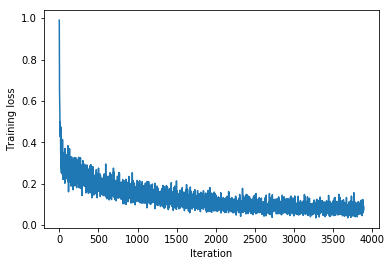

In [44]:
import matplotlib.pyplot as plt

plt.plot(tf_model_trained.get_variable("loss_history")[10:])
plt.xlabel("Iteration")
plt.ylabel("Training loss")
plt.show()

### Make predictions

Let's make some predictions. We define ```tf_predict_pipeline``` that consists of several steps. First, we import trained model from ```tf_model_trained``` and define pipeline variable ```predictions_list``` that will store predicted probabilities. Then we load and preprocess signals without targets. Finally, we apply ```predict_model```  action to get predictions.

In [45]:
tf_predict_pipeline = (bf.Pipeline()
                       .import_model("conv_model", tf_model_trained)
                       .init_variable("predictions_list", init_on_each_run=list)
                       .load(fmt="wfdb", components=["signal", "meta"])
                       .random_split_signals(3000, 1)
                       .apply_transform(func=np.transpose, src='signal', dst='signal', axes=[0, 2, 1])
                       .predict_model('conv_model', make_data=tf_make_data,
                                      fetches='output', save_to=V("predictions_list"), mode="e"))

Run ```tf_predict_pipeline``` on the test part of the dataset:

In [46]:
tf_res = (afds.test >> tf_predict_pipeline).run(batch_size=len(afds.test), n_epochs=1, shuffle=False, drop_last=False)

Consider predicted values and true labels. Predictions are stored in ```predictions_list``` and we get them through ```get_variable``` method:

In [47]:
import pandas as pd
pd.options.display.float_format = '{:.2f}'.format

pred_proba = pd.DataFrame([x[0] for x in tf_res.get_variable("predictions_list")], 
                    index=afds.test.indices, columns=['AF prob'])

true_labels = (pd.read_csv(AF_SIGNALS_REF, index_col=0, names=['True label'])
               .replace(['N', 'O', '~'], 'NO'))

df = pd.merge(pred_proba, true_labels, how='left', left_index=True, right_index=True)
df.head(10)

,AF prob,True label
A00001,0.00,NO
A00002,0.00,NO
A00003,0.00,NO
A00004,0.98,A
A00005,0.32,A
A00006,0.01,NO
A00007,0.02,NO
A00008,0.00,NO
A00009,0.88,A
A00010,0.00,NO


Print some classification metrics to quantify the quality of predictions:

In [48]:
from sklearn.metrics import classification_report

print(classification_report((df['True label'] == 'A').astype(int),
                            (df['AF prob'].astype(float) >= 0.5).astype(int),
                            target_names = ['NO', 'A']))

             precision    recall  f1-score   support

         NO       0.97      0.97      0.97      1533
          A       0.72      0.77      0.75       173

avg / total       0.95      0.95      0.95      1706



We observe that our simple ```TFConvModel``` is too simple to detect atrial fibrillation reasonably well. Try to increase model depth and number of filters and see how it improves the classification.

## Neural network with Keras

![](https://devblogs.nvidia.com/parallelforall/wp-content/uploads/2017/08/Keras_Logo_358x230.png)

Let's define convolutional block from Keras layers:

In [50]:
from keras.layers import Conv1D, MaxPooling1D, \
                         BatchNormalization, Activation

def keras_conv_block(input_layer, nb_filters):
    conv = Conv1D(nb_filters, 4)(input_layer)
    bnorm = BatchNormalization(momentum=0.9)(conv)
    relu = Activation('relu')(bnorm)
    output = MaxPooling1D()(relu)
    return output    

Using TensorFlow backend.


### Define model architecture

In general, model is a complex object that includes model architecture, train/predict methods and some others features. However, if you are within Keras, most of features are implemented in class ```KerasModel``` from ``batchflow.models.keras``. So, to build a custom model we define a class ```KerasConvModel``` that extends class ```KerasModel``` and set model architecture within ```_build``` method. Note that ```_build``` is expected to return the first and the last layer of the model. Note also the we do not hardcode input shape and sequence of filter sizes, instead we will obtain these parameters from pipeline.

In [51]:
from cardio.batchflow.models.keras import KerasModel
from keras.layers import Input, Flatten, Dense, GlobalMaxPooling1D

class KerasConvModel(KerasModel):
    def _build(self, **kwargs):
        x = Input(kwargs['input_shape'])
        conv = x
        for nb_filters in kwargs['filters']:
            conv = keras_conv_block(conv, nb_filters)
        flat = GlobalMaxPooling1D()(conv)
        output = Dense(2, activation='softmax')(flat)
        return x, output

### Configure model

```KerasConvModel``` is a dynamic model and will receive configuration parameters from pipeline. We collect required configuration parameters in dict with name ```model_config``` that will be passed to pipeline. Note how we set ```input_shape```. Since batches will appear only when pipeline will be run, a specific substitution rule is required to obtain batch shape. This rule is given by named expression ```F```, which accepts ```batch``` and returns shape of batch items. Read more about named expressions in [documentation](https://analysiscenter.github.io/batchflow/intro/named_expr.html).

In [52]:
from cardio.batchflow import F

model_config = {
    "input_shape": F(lambda batch: batch.signal[0].shape[1:]),
    "loss": "binary_crossentropy",
    "optimizer": "adam",
    'filters': [4, 4, 8, 8, 16, 16, 32, 32]
}

Function ```make_data``` defines what is `x` (features) and what is `y` (tragets) for our model. We declare that batch component ```signal``` is `x`, while batch component ```target``` is `y`.

In [53]:
def make_signals(batch):
    return np.array([segment for signal in batch.signal for segment in signal])

def make_targets(batch):
    n_reps = [signal.shape[0] for signal in batch.signal]
    return np.repeat(batch.target, n_reps, axis=0)

def keras_make_data(batch, **kwagrs):
    if any(elem is None for elem in batch.target):
        return {'x': make_signals(batch)}
    else:
        return {'x': make_signals(batch), 'y': make_targets(batch)}

### Train pipeline

Combine all together in a single train pipeline. In the beginning we initialize model ```KerasConvModel``` and indicate configuration parameters. Then we add preprocess pipeline. In the end we add action ```train_model``` and indicate ```make_data``` functions. Output of ```train_model``` (loss on each batch) will be saved to pipeline variable ```loss_history```: 

In [54]:
from cardio.batchflow import Pipeline, V

with Pipeline() as p:
    keras_train_pipeline = (p.init_model("dynamic", KerasConvModel, name="conv_model", config=model_config)
                            +
                            p.init_variable("loss_history", init_on_each_run=list)
                            +
                            preprocess_pipeline
                            +
                            p.binarize_labels()
                            +
                            p.train_model('conv_model', make_data=keras_make_data, 
                                          save_to=V("loss_history"), mode="a"))

Pipeline for training Keras model is ready. Run it:

In [55]:
keras_model_trained = (afds.train >> keras_train_pipeline).run(batch_size=256, n_epochs=150, shuffle=True, drop_last=True)

Plot loss history:

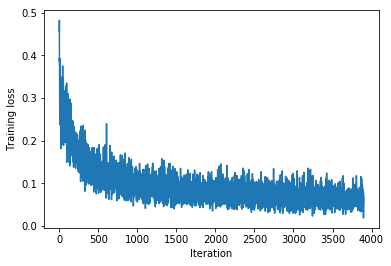

In [56]:
import matplotlib.pyplot as plt

plt.plot(keras_model_trained.get_variable("loss_history"))
plt.xlabel("Iteration")
plt.ylabel("Training loss")
plt.show()

### Make predictions

Making prediction is the same as making prediction with TensorFlow model. We define ```keras_predict_pipeline``` that differs from ```keras_train_pipeline``` in two things. First, we import trained model from ```keras_model_trained instead``` of initializing a new model. Second, train_model action is replaced with predict_model action.

In [57]:
keras_predict_pipeline = (bf.Pipeline()
                          .import_model("conv_model", keras_model_trained)
                          .init_variable("predictions_list", init_on_each_run=list)
                          .load(fmt="wfdb", components=["signal", "meta"])
                          .random_split_signals(3000, 1)
                          .apply_transform(func=np.transpose, src='signal', dst='signal', axes=[0, 2, 1])
                          .predict_model('conv_model', make_data=keras_make_data,
                                         save_to=V("predictions_list"), mode="e"))

Run ```keras_predict_pipeline``` on the test part of the dataset:

In [58]:
keras_res = (afds.test >> keras_predict_pipeline).run(batch_size=len(afds.test), n_epochs=1,
                                                      shuffle=False, drop_last=False)

Consider predicted values and true labels. Predictions are stored in ```prediction_list``` and we get them through ```get_variable``` method:

In [59]:
import pandas as pd
pd.options.display.float_format = '{:.2f}'.format

pred_proba = pd.DataFrame([x[0] for x in keras_res.get_variable("predictions_list")], 
                    index=afds.test.indices, columns=['AF prob'])

true_labels = (pd.read_csv(AF_SIGNALS_REF, index_col=0, names=['True label'])
               .replace(['N', 'O', '~'], 'NO'))

df = pd.merge(pred_proba, true_labels, how='left', left_index=True, right_index=True)
df.head(10)

,AF prob,True label
A00001,0.00,NO
A00002,0.00,NO
A00003,0.00,NO
A00004,1.00,A
A00005,0.79,A
A00006,0.00,NO
A00007,0.01,NO
A00008,0.00,NO
A00009,1.00,A
A00010,0.00,NO


Print some classification metrics to quantify the quality of predictions:

In [60]:
from sklearn.metrics import classification_report

print(classification_report((df['True label'] == 'A').astype(int),
                            (df['AF prob'].astype(float) >= 0.5).astype(int),
                            target_names = ['NO', 'A']))

             precision    recall  f1-score   support

         NO       0.98      0.96      0.97      1533
          A       0.71      0.79      0.75       173

avg / total       0.95      0.95      0.95      1706



We observe that our simple ```ConvModel``` is too simple to detect atrial fibrillation reasonably well. Try to increase model depth and number of filters and see how it improves the classification.

# General models

![](https://www.add-for.com/wp-content/uploads/2016/11/frameworks.jpg)

With CardIO you can implement arbitrary model, train it within pipeline and make inference. Models can be _static_ or _dynamic_. Static model has all its hyperparameters (e.g. data input shape) hardcoded inside the model and they remain unchanged. In contrast, dynamic model receives its parameters from pipeline and thus parameters can be varied.

As an example we will create a logistic regression model using Numpy and separate signals with atrial fibrillation from other signals on a basis of some features. The example, however, will be very rudimentary, since we consider only 6 signals (2 of them have atrial fibrillation) and features are the mean and standard deviation of signal.

The model will be _dynamic_ and will accept input data of arbitrary shape. So you can generate more signal features and use the same model without any changes.

Consider ```gen_features``` function that gets batch of signals as argument and returns computed features (normalized within the batch):

In [61]:
def gen_features(x, *args, **kwargs):
    _ = args, kwargs
    features = np.array([[np.mean(s), np.std(s)] for s in x])
    features -= np.mean(features, axis=0) 
    features /= np.linalg.norm(features, axis=0)
    return features

### Define model architecture

A model of logistic regression consists of weights array, train and inference methods. To incorporate custom model into pipeline it should inherit ```BaseModel``` class and its API. So we define a class ```LogisticModel``` that extends ```BaseModel``` and overwrite dummy methods ```build```, ```train``` and ```predict``` from ```BaseModel```. See the realization below. Note that size of weights array and learning rate are configuration parameters of the model and will be passed from pipeline later.

In [62]:
from cardio.batchflow.models import BaseModel

class LogisticModel(BaseModel):
    def __init__(self, *args, **kwargs):
        self.weights = np.array([])
        self.learning_rate = 0.01
        super().__init__(*args, **kwargs)
            
    def build(self, *args, **kwargs):
        self.weights = np.random.rand(self.config['input_shape'])
        if 'learning_rate' in self.config:
            self.learning_rate = self.config['learning_rate']
    
    @staticmethod
    def sigmoid(x):
        return 1. / (1. + np.exp(-x))
    
    @staticmethod
    def sign(x):
        sign = np.ones(len(x))
        return -1. if x < 0. else 1.
    
    def train(self, x, y, *args, **kwargs):
        logits = np.dot(x, self.weights).reshape((-1, 1))
        sign = np.sign(logits)
        gradient = np.mean(sign * x * (self.sigmoid(abs(logits)) - sign * y.reshape((-1, 1)) - 0.5 + 0.5 * sign), axis=0)
        self.weights -= self.learning_rate * gradient
        loss = np.mean(np.maximum(logits, 0) - logits * y.reshape((-1, 1)) + np.log(1 + np.exp(-abs(logits))))
        return loss
    
    def predict(self, x, *args, **kwargs):
        scores = np.dot(x, self.weights)
        return self.sigmoid(scores)

### Configure model

A size of weights array (which is equal to a number of features for regression + interception term) is a hyperparameter of the ```LogisticModel```. In ```model_config``` we specify that it will be computed directly from batch shape. Thus we can apply the same model to arbitrary number of features.

In [63]:
from cardio.batchflow import F

model_config = {
    "input_shape": F(lambda batch: batch.signal[0].size + 1),
    "learning_rate": 1.
}

Function ```make_data``` declares what is ```x``` and what is ```y``` for regression. Note that we will use the same ```make_data``` for training and inference  and that for inference we have no targets:

In [64]:
def make_data(batch, **kwagrs):
    if any(elem is None for elem in batch.target):
        return {'x': np.concatenate([np.array(list(batch.signal)), np.ones((len(batch), 1))], axis=1)}
    else:
        return {'x': np.concatenate([np.array(list(batch.signal)), np.ones((len(batch), 1))], axis=1),
                'y': np.array(list(batch.target))[:, 0]}

### Train model

The train pipeline consists of actions that
* initialize ```LogisticModel```
* initialize variable ```loss_history``` that will store loss
* load and preprocess signals
* generate signal features
* train model on batch.

Below we define ```log_train_pipeline```. Note that it also saves batch to the pipeline variable ```batch```. We will use it later for visualization of features and separating hyperplane.

In [65]:
import numpy as np
import cardio.batchflow as bf
from cardio.batchflow import Pipeline, V, B

log_train_pipeline = (bf.Pipeline()
                     .init_model("dynamic", LogisticModel, name="log_model", config=model_config)
                     .init_variable("loss_history", init_on_each_run=list)
                     .init_variable("batch", init_on_each_run=list)
                     .load(fmt="wfdb", components=["signal", "meta"])
                     .load(src="../cardio/tests/data/REFERENCE.csv", fmt="csv", components="target")
                     .drop_labels(["~"])
                     .rename_labels({"N": "NO", "O": "NO"})
                     .binarize_labels()
                     .apply_transform_all(func=gen_features, src='signal', dst='signal')
                     .update_variable('batch', B(), mode='w')
                     .train_model('log_model', make_data=make_data,
                                  save_to=V("loss_history"), mode="a"))

Run ```log_train_pipeline```:

In [66]:
eds = EcgDataset(path="../cardio/tests/data/A*.hea", no_ext=True, sort=True)
log_model_trained = (eds >> log_train_pipeline).run(batch_size=6, n_epochs=100, shuffle=True, drop_last=True)

Now the trained model is stored in ```log_model_trained```. Let's plot the history of training loss:

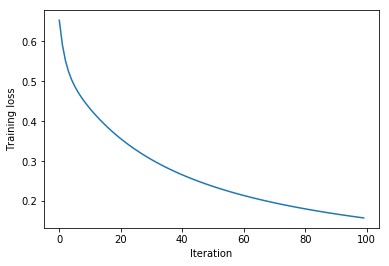

In [67]:
import matplotlib.pyplot as plt

plt.plot(log_model_trained.get_variable("loss_history"))
plt.xlabel("Iteration")
plt.ylabel("Training loss")
plt.show()

Since the loss decreases to zero we can hope that the model separates successfully both classes. Let's plot the signal features and the separating hyperplane. Red color corresponds to signals with atrial fibrillation.

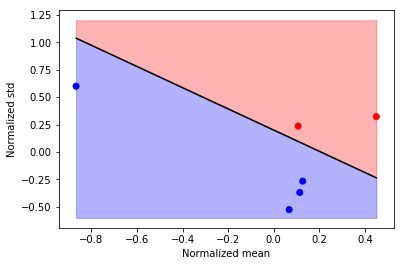

In [68]:
import matplotlib.pyplot as plt

batch = log_model_trained.get_variable("batch")
signal, target = batch.signal, batch.target
colors = np.array(['b' if t == 0 else 'r' for t in target[:, 0]])
weights = log_model_trained.get_model_by_name("log_model").weights

order = np.argsort(signal[:, 0])
x = signal[order, 0]
y = signal[order, 1]

plt.scatter(x, y, c=colors[order])
plt.plot(x, -(x * weights[0] + weights[2]) / weights[1], c='black')

plt.axes().fill_between(x, -(x * weights[0] + weights[2]) / weights[1], 1.2, color='r', alpha=0.3)
plt.axes().fill_between(x, -0.6, -(x * weights[0] + weights[2]) / weights[1], color='b', alpha=0.3)
plt.xlabel("Normalized mean")
plt.ylabel("Normalized std")
plt.show()

We observe that two classes are separated by the model indeed. Hovewer, it makes no sence to rely on these features for practical use. 

### Make prediction

For inference we create an inference pipeline. It is a bit shorter in comparison to the train pipeline. We import trained model instead of initializing a new one, load and preprocess signals, generate features and make prediction on batch:

In [69]:
log_predict_pipeline = (bf.Pipeline()
                        .import_model("log_model", log_model_trained)
                        .init_variable("predictions_list", init_on_each_run=list)
                        .load(fmt="wfdb", components=["signal", "meta"])
                        .apply_transform_all(func=gen_features, src='signal', dst='signal')
                        .predict_model('log_model', make_data=make_data,
                                       save_to=V("predictions_list"), mode="e"))

Run inference. We exploit the same dataset as for training, so this step is for illustration only:

In [70]:
log_res = (eds >> log_predict_pipeline).run(batch_size=len(eds.indices),
                                            n_epochs=1, shuffle=False, drop_last=False)

Consider predicted values. They are stored in ```predictions_list``` and we get them through ```get_variable``` method:

In [71]:
pd.options.display.float_format = '{:.2f}'.format

pred_proba = pd.DataFrame([x for x in log_res.get_variable("predictions_list")], 
                    index=eds.indices, columns=['AF prob'])

true_labels = (pd.read_csv('../cardio/tests/data/REFERENCE.csv', index_col=0, names=['True label'])
               .replace(['N', 'O', '~'], 'NO'))

df = pd.merge(pred_proba, true_labels, how='left', left_index=True, right_index=True)
df.head(10)

,AF prob,True label
A00001,0.04,NO
A00002,0.10,NO
A00004,0.93,A
A00005,0.66,A
A00008,0.16,NO
A00013,0.11,NO


The point, however, is that regression models substantially rely on custom generated features. It is incredibly difficult to find an appropriate set of features for more or less reliable detection of heart diseases. In contrast, neural networks are able to generate much more complex features that highlight arrhythmia and other diseases effectively.

# Summary

![](https://thumbs.dreamstime.com/t/elecktrocardiogram-ecg-graph-pulse-isolated-white-76413865.jpg)


This is the end of the Notebook 3. Let's summarize what we did:
* we trained built-in CardIO model to isolate fiducial points within ECG signals and detect atrial fibrillation
* built simple convolutional neural network using
    * layers and blocks from ``batchflow.models``
    * TensorFlow
    * Keras
* built logistic regression model and trained it within pipeline.

Now you have a full range of possibilities to start you own research in ECG.

See previous [Notebook 1](https://github.com/analysiscenter/cardio/blob/master/tutorials/I.CardIO.ipynb) and [Notebook 2](https://github.com/analysiscenter/cardio/blob/master/tutorials/II.Pipelines.ipynb) on actions and pipelines if you need to refresh these topics.

In the next [Notebook 4](https://github.com/analysiscenter/cardio/blob/master/tutorials/IV.Research.ipynb) we will run multiple experiments with ``Research`` module of ``Batchflow``.